# CYB80001 System Security Project
Prepared by **Derui (Derek) Wang**

---

# Session 3B - Fast Gradient Sign and Projected Gradient Descent

In this session, we will implement **Fast Gradient Sign Method (FGSM) and Projected Gradient Descent (PGD) attacks** based on **Tensorflow** and **Keras**. We will then apply the attacks to a keras classifier to evaluate the attacks.



## Content


### Part 1 Using Tensorflow and Keras together

1.1 [Load a pre-trained Keras model into a computational graph](#1_1)

1.2 [Using a pre-trained Keras model with Tensorflow variables](#1_2)


### Part 2 Using Tensorflow to implement FGSM

2.1 [Implementing FGSM](#2_1)

2.2 [Testing FGSM](#2_2)

2.3 [FGSM Exercise](#2_3)

### Part 3 Using Tensorflow to implement PGD

3.1 [Implementing PGD](#3_1)

3.2 [Testing PGD](#3_2)

3.3 [PGD Exercise](#3_3)


---

# Part 1. Using Tensorflow and Keras together 

Writing attacks means that you need to build your attack algorithms (in Tensorflow) and attack a victim model via its APIs. In this part, we will learn how to integrate your attacks in Tensorflow and a victim classifiers in Keras. 

---

<a id = "1_1"></a>

## 1.1 Load a pre-trained Keras model into a computational graph

In this section, we will explore how to craft adversarial examples against a DNN classifier. We will use tensorflow to implement the adversarial example attacks.

We will use craft adversarial examples of **MNIST** data. We can import the dataset from keras.

In [1]:
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# we normalise the pixels to values between 0 and 1
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = np.float32(X_train/255.)
X_test = np.float32(X_test/255.)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('data loaded, training x:{0}, y:{1}; test x:{2}, y{3}.'.format(X_train.shape,
                                                                     X_test.shape,
                                                                     y_train.shape,
                                                                     y_test.shape))


Using TensorFlow backend.


data loaded, training x:(60000, 28, 28, 1), y:(10000, 28, 28, 1); test x:(60000, 10), y(10000, 10).


The target classifier is a trained one. Therefore, we need to retain the model weights during out attack. How can we do this? Recall that Tensorflow has a graph construction phase and a execution phase. We first need to load the target classifier. 

For example, we can load `mnist_cnn_model.h5` we trained in the Session 3A using `load_model` function from Keras.

In [2]:
from keras.models import load_model

target_classifier = load_model('mnist_cnn_model.h5')
print('Evaluate the loaded model')
print(f'Accuracy of the loaded model: {target_classifier.evaluate(X_test, y_test)[1]}')

W1014 15:35:48.266674 140736682697664 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1014 15:35:48.306151 140736682697664 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1014 15:35:48.381007 140736682697664 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1014 15:35:48.495921 140736682697664 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:

Evaluate the loaded model
10000/10000 [==============================] - 3s 349us/step
Accuracy of the loaded model: 0.9916


Let's build a tensorflow graph and use `mnist_cnn_model.h5` as part of the graph.

In [3]:
import tensorflow as tf
from keras import backend as K

tf.reset_default_graph()

sess = tf.Session()

#make sure that Keras model use the same session with tensorflow
K.set_session(sess)

target_classifier = load_model('mnist_cnn_model.h5')

# buid the keras model into a tensorflow graph
# placeholders to receive input feature matrix and labels
x = tf.placeholder(tf.float32, (X_test.shape[0],
                                X_test.shape[1],
                                X_test.shape[2],
                                X_test.shape[3]))
y = tf.placeholder(tf.float32, (y_test.shape[0], y_test.shape[1]))
output =  target_classifier(x)

# execute the graph
prediction_on_new_data = sess.run(output, feed_dict={x: X_test, y: y_test})
print(f'Predicted labels: {np.argmax(prediction_on_new_data, axis=-1)}')
print(f'True labels: {np.argmax(y_test, axis=-1)}')


Predicted labels: [7 2 1 ... 4 5 6]
True labels: [7 2 1 ... 4 5 6]


We can see that we can run the loaded  `mnist_cnn_model.h5` as a tensorflow graph. You must set the keras session and the tensorflow session to be a same one by using `K.set_session(sess)`.

---

<a id = "1_2"></a>

## 1.2 Using a pre-trained Keras model with Tensorflow variables

Remember that if you have used Tensorflow **variables** in the graph, you must run initialisation after the graph is constructed. 

In the previous section, there is no Tensorflow variable in the graph. Therefore, we did the initialisation **prior to constructing the graph**. In this part, we will experiment with the cases in which we have Tensorflow variables in the graph.

First, we add a variable `z` into the graph. **The following code snippet will intentionally raise an error**:

In [ ]:
tf.reset_default_graph()

sess = tf.Session()

#make sure that Keras model use the same session with tensorflow
K.set_session(sess)

target_classifier = load_model('mnist_cnn_model.h5')
    
# buid the keras model into a tensorflow graph
# placeholders to receive input feature matrix and labels
x = tf.placeholder(tf.float32, (X_test.shape[0],
                                X_test.shape[1],
                                X_test.shape[2],
                                X_test.shape[3]))
y = tf.placeholder(tf.float32, (y_test.shape[0], y_test.shape[1]))

# We use a variable here
z = tf.Variable(np.zeros((X_test.shape[0],
                          X_test.shape[1],
                          X_test.shape[2],
                          X_test.shape[3])), dtype=tf.float32, name='tf_variable_z')

new_x = tf.clip_by_value(x + z, 0, 1)
output =  target_classifier(new_x)

# execute the graph
prediction_on_new_data = sess.run(output, feed_dict={x: X_test, y: y_test})
print(f'Predicted labels: {np.argmax(prediction_on_new_data, axis=-1)}')
print(f'True labels: {np.argmax(y_test, axis=-1)}')

You recieve an error here. To resolve it, **you must run an initialisation operation after declaring all the variables, right before the learning loop**. Let's add the initialisation operation and run the code again:

In [ ]:
tf.reset_default_graph()

sess = tf.Session()

#make sure that Keras model use the same session with tensorflow
K.set_session(sess)

target_classifier = load_model('mnist_cnn_model.h5')
    
# buid the keras model into a tensorflow graph
# placeholders to receive input feature matrix and labels
x = tf.placeholder(tf.float32, (X_test.shape[0],
                                X_test.shape[1],
                                X_test.shape[2],
                                X_test.shape[3]))
y = tf.placeholder(tf.float32, (y_test.shape[0], y_test.shape[1]))

# We use a variable here
z = tf.Variable(np.zeros((X_test.shape[0],
                          X_test.shape[1],
                          X_test.shape[2],
                          X_test.shape[3])), dtype=tf.float32, name='tf_variable_z')

new_x = tf.clip_by_value(x + z, 0, 1)
output =  target_classifier(new_x)

# define an initialisation operation to initialise all variables
init = tf.global_variables_initializer()

# execute the graph
# run the initialisation
sess.run(init)

prediction_on_new_data = sess.run(output, feed_dict={x: X_test, y: y_test})
print(f'Predicted labels: {np.argmax(prediction_on_new_data, axis=-1)}')
print(f'True labels: {np.argmax(y_test, axis=-1)}')

Now there is no error now. However, **the prediction results become incorrect**. This is because the Keras model was initialised as well.

Then, **how can we use Tensorflow variables and keras model together?** Let's simply change the order of the initialisation operation and model loading.

In [ ]:
tf.reset_default_graph()

sess = tf.Session()

#make sure that Keras model use the same session with tensorflow
K.set_session(sess)

# placeholders to receive input feature matrix and labels
x = tf.placeholder(tf.float32, (X_test.shape[0],
                                X_test.shape[1],
                                X_test.shape[2],
                                X_test.shape[3]))
y = tf.placeholder(tf.float32, (y_test.shape[0], y_test.shape[1]))

# We use a variable here
z = tf.Variable(np.zeros((X_test.shape[0],
                          X_test.shape[1],
                          X_test.shape[2],
                          X_test.shape[3])), dtype=tf.float32, name='tf_variable_z')

# Put the init op before loading model
init = tf.global_variables_initializer()

# load model after the init op
target_classifier = load_model('mnist_cnn_model.h5')
new_x = tf.clip_by_value(x + z, 0, 1)

# buid the keras model into a tensorflow graph
output =  target_classifier(new_x)

# execute the graph
# run the initialisation
sess.run(init)
prediction_on_new_data = sess.run(output, feed_dict={x: X_test, y: y_test})
print(f'Predicted labels: {np.argmax(prediction_on_new_data, axis=-1)}')
print(f'True labels: {np.argmax(y_test, axis=-1)}')

Now we have the correct predictions. **As a conclusion, we can first define an initialisation operation after all Tensorflow variables and then load a Keras model into the graph**.

---

# Part 2. Using Tensorflow to implement FGSM

---

<a id = "2_1"></a>

## 2.1 Implementing FGSM
We will implement the FGSM attack from scratch in this part.

We use `categorical_crossentropy` from Keras, as the adversarial loss function.

We first implement **non-targeted** FGSM (the misclassification calss is not specified). In this case, we are going to increase the cross-entropy loss.

In [4]:
import tensorflow as tf
from keras import backend as K

# FGSM hyper-parameter
eps = 0.15
benign_example = X_test[4:5]
bening_y = y_test[4:5]

tf.reset_default_graph()
sess = tf.Session()

#make sure that Keras model use the same session with tensorflow
K.set_session(sess)

# placeholders to receive input feature matrix and labels
x = tf.placeholder(tf.float32, (benign_example.shape[0],
                                benign_example.shape[1],
                                benign_example.shape[2],
                                benign_example.shape[3]))
y = tf.placeholder(tf.float32, (bening_y.shape[0], bening_y.shape[1]))

# Put the init op before loading model
init = tf.global_variables_initializer()

# load model after the init op
target_classifier = load_model('mnist_cnn_model.h5')
target_classifier.summary()

# buid the keras model into a tensorflow graph
output =  target_classifier(x)

# adversarial loss function
loss = K.categorical_crossentropy(output, y)

# FGSM attack steps
dy_dx, = tf.gradients(loss, x)
x_adv = tf.stop_gradient(x + eps * tf.sign(dy_dx))
x_adv = tf.clip_by_value(x_adv, 0, 1)

# execute the graph
# run the initialisation
sess.run(init)
fgsm_x = sess.run(x_adv, feed_dict={x: benign_example, y: bening_y})
print('Complete')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Normal_inputs (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
C1 (Conv2D)                  (None, 28, 28, 32)        320       
_________________________________________________________________
C2 (Conv2D)                  (None, 28, 28, 32)        9248      
_________________________________________________________________
MP1 (MaxPooling2D)           (None, 14, 14, 32)        0         
_________________________________________________________________
Flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
D1 (Dense)                   (None, 200)               1254600   
_________________________________________________________________
logits (Dense)               (None, 10)                2010      
__________

`fgsm_x` is the adversarial example. We can plot the MNIST example and its FGSM example using Matplotlib.

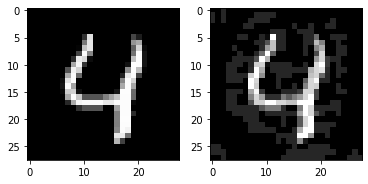

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(benign_example.reshape(28,28), cmap='gray')
axes[1].imshow(fgsm_x.reshape(28,28), cmap='gray')
plt.show()


---

<a id = "2_2"></a>

## 2.2 Testing FGSM

We can check the classification results of these two examples:

In [7]:
# Input the examples into the classifier for classification
print(f'Keras classifier prediction on the benign example: {np.argmax(target_classifier.predict(benign_example))}')
print(f'Keras classifier prediction on the fgsm example: {np.argmax(target_classifier.predict(fgsm_x))}')

Keras classifier prediction on the benign example: 4
Keras classifier prediction on the fgsm example: 9


We can see that **the fgsm example is misclassified**.

---

<a id = "2_3"></a>

## 2.3 FGSM Exercise

We have implemented the **non-targeted FGSM** attack in the above code snippets. 

As an exercise, you can implement the **targeted FGSM** attack which produces an adversarial example of **digit 4**. You can set the misclassification target to **0**. You can reuse the above code and data in this exercise.

In [ ]:
# Please complete the exercise in this ocde cell.



---

# Part 3. Using Tensorflow to implement PGD

---

<a id = "3_1"></a>

## 3.1 Implementing PGD

We will implement the PGD attack from scratch in this part.

We use `categorical_crossentropy` from Keras, as the adversarial loss function.

We first implement **non-targeted** PGD (the misclassification calss is not specified). We will write the attack steps in a function named `pgd_attack`.

In [8]:
import tensorflow as tf
from keras import backend as K

def pgd_attack(model, x, y, max_iter=1000, clip_min=0., clip_max=1.):
    def _cond(x, i):
        return tf.less(i, max_iter)

    def _body(x, i):
        logits = model(x)
        loss = K.categorical_crossentropy(logits, y)
        dy_dx, = tf.gradients(loss, x)
        x = tf.stop_gradient(x + dy_dx)
        x = tf.clip_by_value(x, clip_min, clip_max)
        return x, i+1
    x_adv, i = tf.while_loop(_cond, _body, (x, 0), back_prop=False, name='pgd_attacker')
    return x_adv

We can then replace the attack steps of the FGSM attack to that of the PGD attack.

In [9]:
# PGD hyper-parameter
MAX_ITER = 5000

benign_example = X_test[4:5]
bening_y = y_test[4:5]

tf.reset_default_graph()
sess = tf.Session()

#make sure that Keras model use the same session with tensorflow
K.set_session(sess)

# placeholders to receive input feature matrix and labels
x = tf.placeholder(tf.float32, (benign_example.shape[0],
                                benign_example.shape[1],
                                benign_example.shape[2],
                                benign_example.shape[3]))
y = tf.placeholder(tf.float32, (bening_y.shape[0], bening_y.shape[1]))

# Put the init op before loading model
init = tf.global_variables_initializer()

# load model after the init op
target_classifier = load_model('mnist_cnn_model.h5')
#target_classifier.layers.pop()
target_classifier.summary()

# Attack steps
x_adv = pgd_attack(target_classifier, x, y, max_iter=MAX_ITER)

# execute the graph
# run the initialisation
sess.run(init)
pgd_x  = sess.run(x_adv, feed_dict={x: benign_example, y: bening_y})
print('Complete')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Normal_inputs (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
C1 (Conv2D)                  (None, 28, 28, 32)        320       
_________________________________________________________________
C2 (Conv2D)                  (None, 28, 28, 32)        9248      
_________________________________________________________________
MP1 (MaxPooling2D)           (None, 14, 14, 32)        0         
_________________________________________________________________
Flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
D1 (Dense)                   (None, 200)               1254600   
_________________________________________________________________
logits (Dense)               (None, 10)                2010      
__________

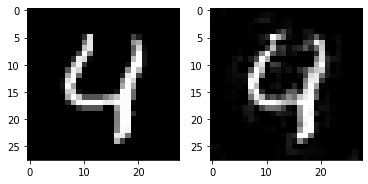

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(benign_example[0].reshape(28,28), cmap='gray')
axes[1].imshow(pgd_x[0].reshape(28,28), cmap='gray')
plt.show()

---

<a id = "3_2"></a>

## 3.2 Testing PGD

We can check the classification results of these two examples:

In [ ]:
# Input the examples into the classifier for classification
print(f'Keras classifier prediction on the benign example: {np.argmax(target_classifier.predict(benign_example))}')
print(f'Keras classifier prediction on the fgsm example: {np.argmax(target_classifier.predict(pgd_x))}')

---

<a id = "3_3"></a>

## 3.3 PGD Exercise

We have implemented the **non-targeted PGD** attack in the above code snippets. 

As an exercise, you can implement the **targeted PGD** attack which produces an adversarial example of **digit 4**. You can set the misclassification target to **0**. You can reuse the above code and data in this exercise.

In [ ]:
# Please complete the exercise in this ocde cell.



---
### <div  style="text-align:center">**THE END**</div>